<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/comment/ch04_02_UNet_multiclass_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.02 UNet-Image segmentation

* 날짜:
* 이름:

## 학습내용
    - Image multiclass segmentation에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Muticlass Segmenation



<p  align='center'>
<img src ='https://miro.medium.com/max/1400/1*B16t8Do6hvuq2Q_2YOM-UQ.png' width=500>
</p>


<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0402-01.PNG?raw=true' width=800>
</p>


In [ ]:
! git clone https://github.com/karolzak/keras-unet

Cloning into 'keras-unet'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1234 (delta 44), reused 75 (delta 34), pack-reused 1136
Receiving objects: 100% (1234/1234), 31.94 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [ ]:
import sys, os, glob
sys.path.append('/content/keras-unet')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import utils, callbacks, models, layers
from keras_unet.models import custom_unet
from scipy.io import loadmat
from tensorflow.keras import backend as K


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## 데이터셋: Crowd Instance-level Human Parsing (CIHP)
---

(https://arxiv.org/abs/1811.12596)

* 38,280개의 다양한 인간 이미지
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/chip.png?raw=true)

In [ ]:
# 데이터셋
!gdown https://drive.google.com/u/4/uc?id=10p_-JQ8T7EuOJ1AWLSQpkUcrIhtRJgK_&export=download

Downloading...
From: https://drive.google.com/u/4/uc?id=10p_-JQ8T7EuOJ1AWLSQpkUcrIhtRJgK_
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:11<00:00, 264MB/s]


In [ ]:
!unzip -q instance-level-human-parsing.zip

# 데이터 전처리

In [ ]:
# Training / Validation / Test
# 경로 구하기
data_dir = '/content/instance-level_human_parsing/instance-level_human_parsing/'
train_img_paths = sorted(glob.glob(f'{data_dir}/Training/Images/*'))
train_mask_paths = sorted(glob.glob(f'{data_dir}/Training/Category_ids/*'))
print(len(train_img_paths), train_img_paths[0])
print(len(train_mask_paths), train_mask_paths[0])

valid_img_paths = sorted(glob.glob(f'{data_dir}/Validation/Images/*'))
valid_mask_paths = sorted(glob.glob(f'{data_dir}/Validation/Category_ids/*'))
print(len(valid_img_paths), valid_img_paths[0])
print(len(valid_mask_paths), valid_mask_paths[0])

28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Images/0000006.jpg
28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Category_ids/0000006.png
5000 /content/instance-level_human_parsing/instance-level_human_parsing//Validation/Images/0000001.jpg
5000 /content/instance-level_human_parsing/instance-level_human_parsing//Validation/Category_ids/0000001.png


In [ ]:
# 좀 더 안전한 방법
#train_img_paths = [mask_path.replace('png', 'jpg') for mask_path in train_mask_paths]
#train_img_paths = [img_path.replace('Category_ids', 'Images') for img_path in train_img_paths]
#print(len(train_img_paths), train_img_paths[0])

In [ ]:
if  tf.random.uniform(shape=[], maxval=1, dtype=tf.float32) > 0.5:
  print('yes')

In [ ]:
N_CLASS = 19
IMG_SIZE = 128

class CIHPgen():
  def __init__(self, img_size, n_class):
    self.img_size = img_size
    self.n_class = n_class

  def path2tensor(self, img_path, mask_path): # 이미지 경로 한개, 마스크 경로 한개
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    return img, mask

  def preprocess(self, img, mask):
    img.set_shape([None, None, 3])
    img = tf.image.resize(images=img, size=[self.img_size, self.img_size])
    img = img / 255.

    mask = tf.one_hot(mask, self.n_class, axis=2)[:,:,:,0]
    mask.set_shape([None, None, self.n_class])
    mask = tf.image.resize(images=mask, size=[self.img_size, self.img_size])
    mask = tf.where(mask>0.5, 1., 0.)

    return img, mask

  def aug(self, img, mask, seed=123): 
    if  tf.random.uniform(shape=[], maxval=1, dtype=tf.float32) > 0.5:
      img = tf.image.random_brightness(img, 0.2)
    if  tf.random.uniform(shape=[], maxval=1, dtype=tf.float32) > 0.5:
      img = tf.image.random_contrast(img, 0.2, 0.5 )

    stacked = tf.concat([img, mask], axis=2)
    stacked = tf.image.random_flip_left_right(stacked, seed=seed)
    #if  tf.random.uniform(shape=[], maxval=1, dtype=tf.float32) > 0.5:
    #  stacked = tf.image.random_crop(stacked, (100, 100, img.shape[-1]+mask.shape[-1]))  # pad
    #  stacked = tf.image.resize_with_crop_or_pad(stacked, self.img_size, self.img_size)  # pad

    img = stacked[:,:,:3]
    mask = stacked[:,:,3:]

    return img, mask
  
  def generator(self, img_paths, mask_paths, aug=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths)) 
    ds = ds.map(self.path2tensor, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(self.preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if aug: ds = ds.map(self.aug)
    ds = ds.batch(32, drop_remainder=True )
    return ds


colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 255
colormap = colormap.astype(np.uint8)
colormap[0]=[200,200,200]

labels = ['background', 'hat', 'hair', 'glove', 'sunglasses', 'upper-clotes', 
          'dress', 'coat', 'socks', 'pants', 'Tosor-skin', 'Scarf', 
          'Skirt', 'Face', 'Left arm', 'Left-leg', 'Right-leg', 
          'Left-shoe', 'Right-shoe']
print(len(labels))

def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def display_data(img, mask, colormap, alpha=0.4):
  out = decode_segmentation_masks(mask, colormap, N_CLASS)

  plt.figure(figsize=(18,3))
  plt.subplot(161)
  plt.imshow(img)
  plt.xticks([]);plt.yticks([])

  plt.subplot(162)
  plt.imshow(img);plt.imshow(out[:,:,:,0], alpha=alpha)
  plt.xticks([]);plt.yticks([])

  plt.subplot(163)
  plt.imshow(out[:,:,:,0])
  plt.xticks([]);plt.yticks([])

  plt.subplot(122)
  plt.bar(range(N_CLASS), [list(mask.numpy().flatten()).count(x) for x in range(N_CLASS)], color = colormap/255)
  plt.yscale('log')
  plt.xticks(range(N_CLASS), labels, rotation=90)
  plt.show()

gen = CIHPgen(IMG_SIZE, N_CLASS)

def display_data_hist(img, mask, yscale=None):
  plt.figure(figsize=(10,3))
  plt.subplot(121);plt.hist(img.numpy().flatten())
  plt.subplot(122);plt.hist(mask.numpy().flatten(), bins=50)
  if yscale=='log': plt.yscale('log')
  plt.show()

19


* img: <dtype: 'uint8'> (334, 500, 3)
* mask: <dtype: 'uint8'> (334, 500, 1)


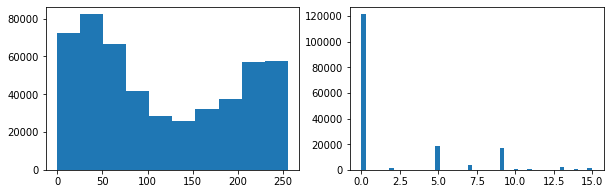

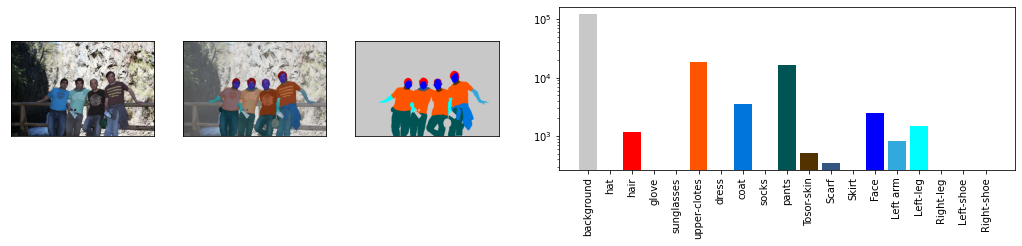

In [ ]:
idx = 11
img, mask = gen.path2tensor(train_img_paths[idx], train_mask_paths[idx])
print('* img:', img.dtype, img.shape)
print('* mask:', mask.dtype, mask.shape)
display_data_hist(img, mask)
display_data(img, mask, colormap)

* img:  <dtype: 'float32'> (128, 128, 3)
* mask:  <dtype: 'float32'> (128, 128, 19) {0.0, 1.0}


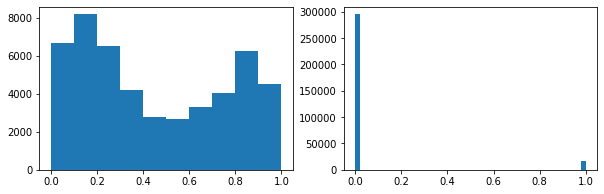

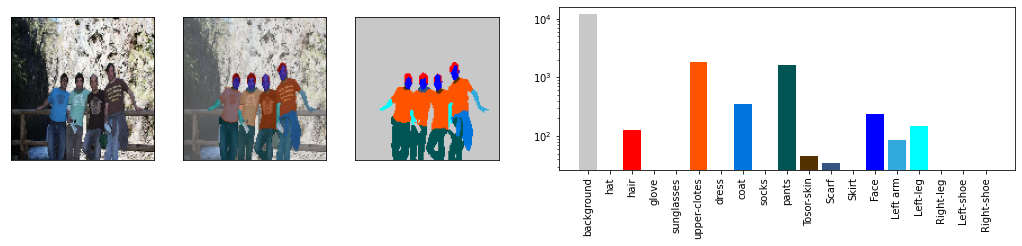

In [ ]:
img_pre, mask_pre = gen.preprocess(img, mask)
print('* img: ', img_pre.dtype, img_pre.shape)
print('* mask: ', mask_pre.dtype, mask_pre.shape, set(mask_pre.numpy().flatten()))
display_data_hist(img_pre,  mask_pre)
mask_arg = tf.argmax(mask_pre, axis=2)[:,:,np.newaxis]
display_data(img_pre, mask_arg, colormap)

* img:  <dtype: 'float32'> (128, 128, 3)
* mask:  <dtype: 'float32'> (128, 128, 19) {0.0, 1.0}


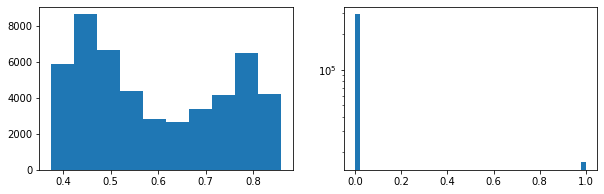

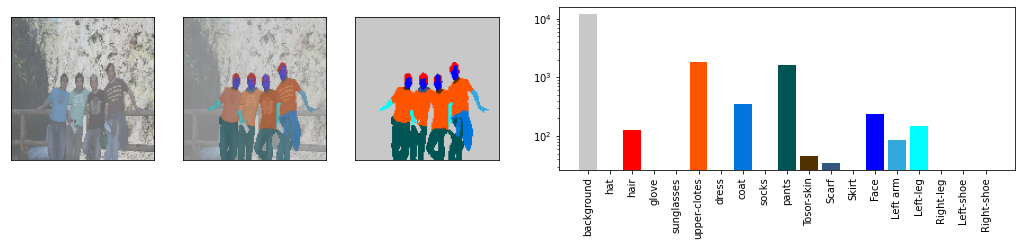

In [ ]:
img_aug, mask_aug = gen.aug(img_pre, mask_pre)
print('* img: ', img_aug.dtype, img_aug.shape)
print('* mask: ', mask_aug.dtype, mask_aug.shape, set(mask_aug.numpy().flatten()))
display_data_hist(img_aug,  mask_aug, 'log')
mask_arg = tf.argmax(mask_aug, axis=2)[:,:,np.newaxis]
display_data(img_aug, mask_arg, colormap)

In [ ]:
train_ds = gen.generator(train_img_paths, train_mask_paths, aug=True)
valid_ds = gen.generator(valid_img_paths, valid_mask_paths, aug=False)
print(train_ds)
print(valid_ds)

<BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 19), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 19), dtype=tf.float32, name=None))>


(32, 128, 128, 3) (32, 128, 128, 19)


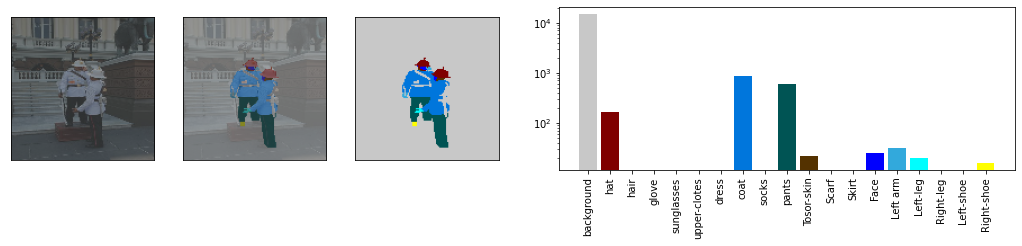

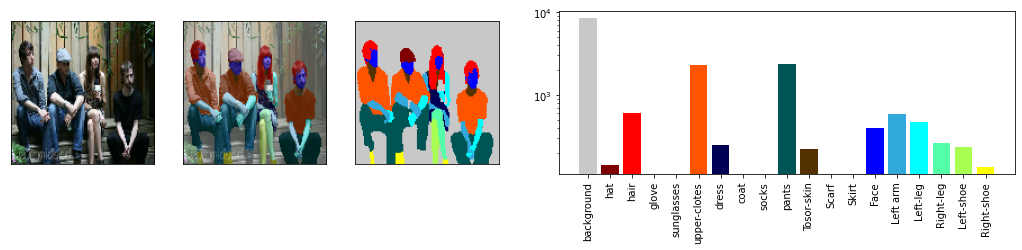

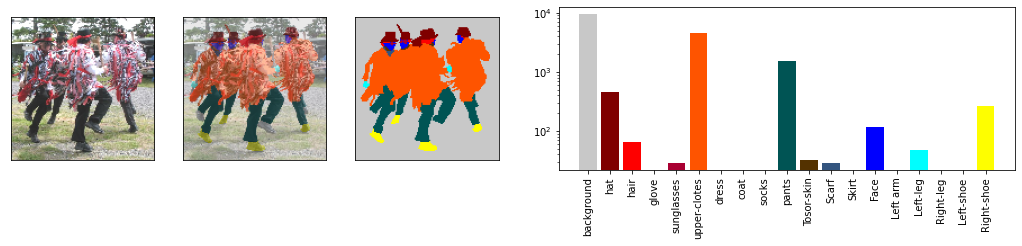

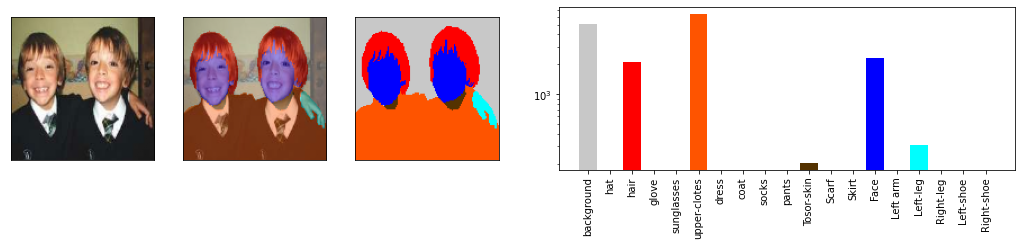

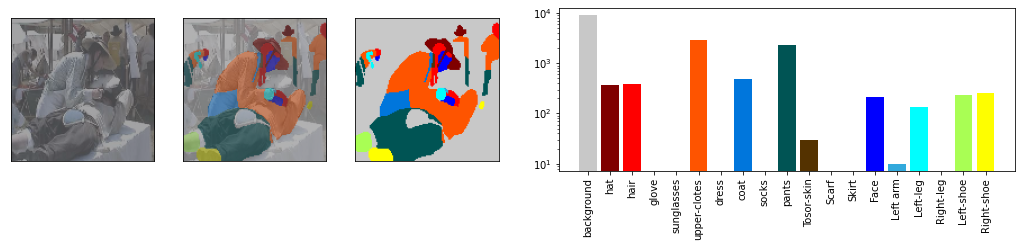

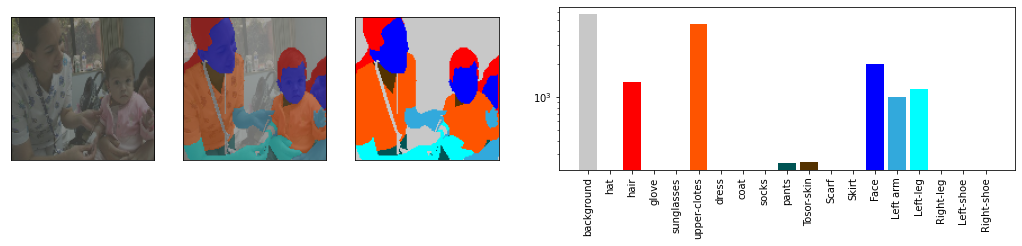

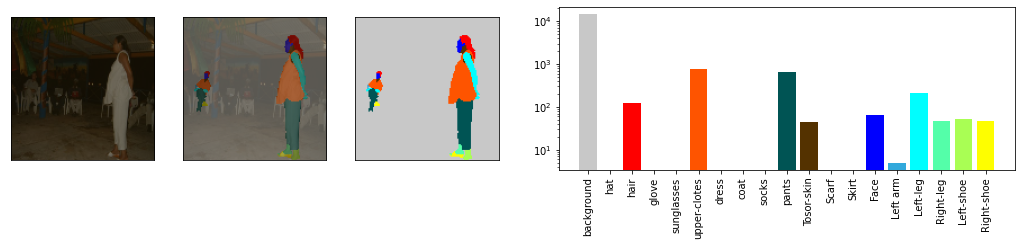

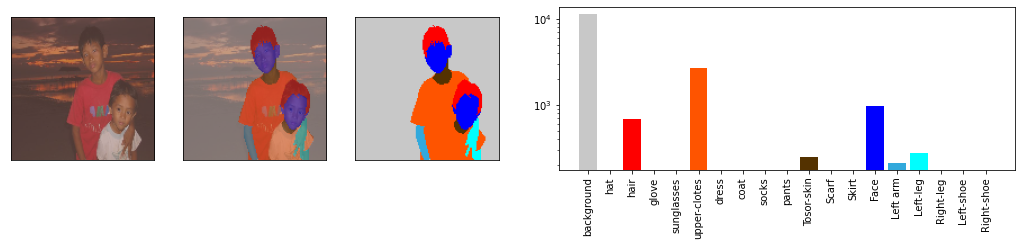

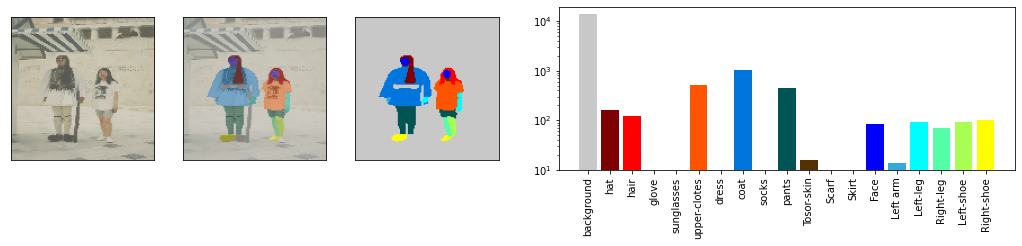

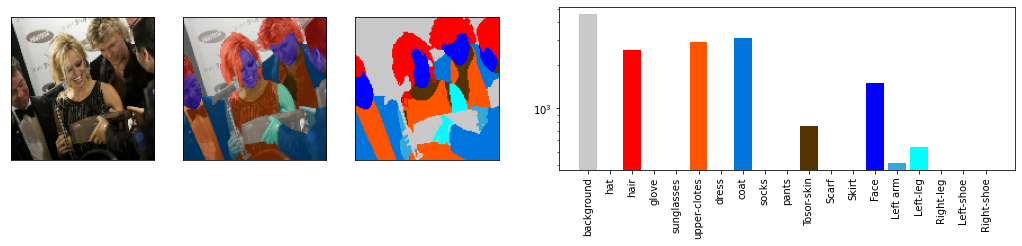

In [ ]:
N = 10
for imgs, masks in train_ds.take(1):
  print(imgs.shape, masks.shape)
  for img, mask in zip(imgs[:N], masks[:N]):
    mask = tf.argmax(mask, axis=2)
    display_data(img, mask[:,:,np.newaxis], colormap)

## 모델 준비
--- 

In [ ]:
model = custom_unet((128,128,3),
                    num_classes=19,
                    filters=32, 
                    output_activation='softmax',
                    )
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 128, 128, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 128, 128, 32  128        ['conv2d_57[0][0]']              
 ormalization)                  )                                                           

In [ ]:
model = models.load_model('model.h5', custom_objects={"iou": iou })

In [ ]:
def iou(y_true, y_pred, smooth=1.):
  intersection = K.sum(y_true * y_pred, axis=(0,1,2))
  union = K.sum(y_true, axis=(0,1,2)) + K.sum(y_pred, axis=(0,1,2))
  return K.mean((intersection + smooth) /  (union - intersection + smooth))
# 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=[iou, 'acc'])

In [ ]:
ckp = callbacks.ModelCheckpoint(filepath='model2.h5',
                                save_best_only=True,
                                monitor='val_loss')
#tb = callbacks.TensorBoard(log_dir='my_log_dir', histogram_freq=1) 
model.fit(train_ds,
          epochs=100,
          validation_data=valid_ds,
          callbacks=[ckp, tb])

### 결과 확인

In [ ]:
model = models.load_model('model2.h5', custom_objects={"iou": iou })

(32, 128, 128) (32, 128, 128)


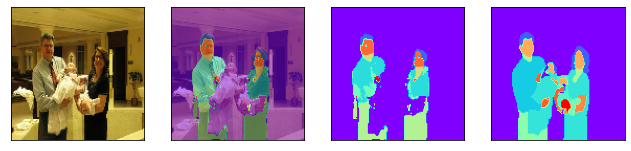

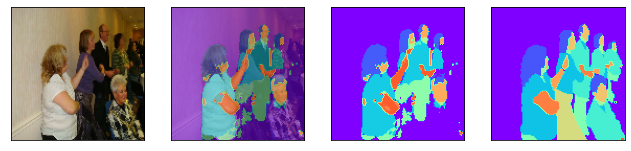

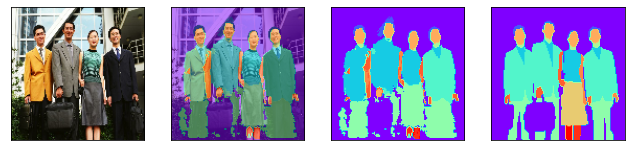

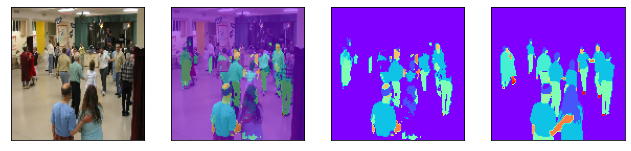

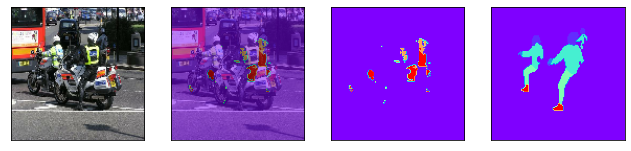

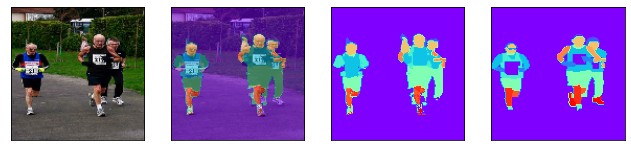

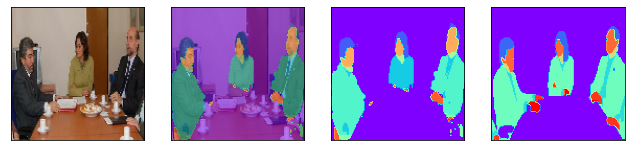

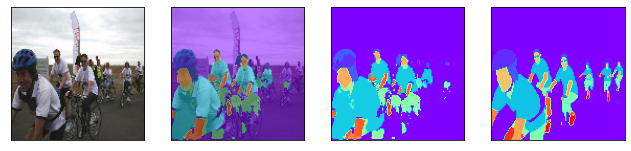

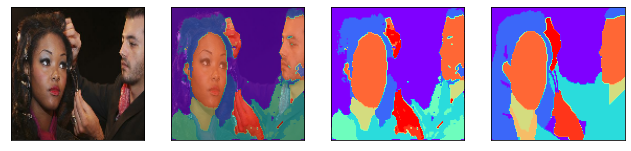

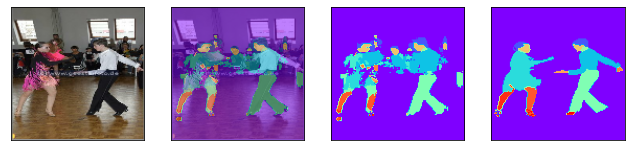

In [ ]:
for imgs, masks in valid_ds.take(1):
  N = 10
  preds = model.predict(imgs)
  preds = tf.argmax(preds, 3)
  masks = tf.argmax(masks, 3)
  print(masks.shape, preds.shape)
  for img, mask, pred in zip(imgs[:N], masks[:N], preds[:N]):
    plt.figure(figsize=(11,4))
    plt.subplot(141);plt.imshow(img);plt.xticks([]);plt.yticks([])
    plt.subplot(142);plt.imshow(img);plt.imshow(pred, alpha=.5, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(143);plt.imshow(pred, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(144);plt.imshow(mask, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.show()

In [ ]:
for imgs, y_true in valid_ds.take(1):
  y_pred = model.predict(imgs)
  print(y_true.shape, y_pred.shape)
  print(iou(y_true, y_true)) 
  print(iou(y_true, y_pred)) 

(32, 128, 128, 19) (32, 128, 128, 19)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.18982577, shape=(), dtype=float32)
